In this notebook we implement a clustering machine learning model to cluster job positing as been related or not related to machine learning.

In [1]:
!pip install wordcloud

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 520.1/520.1 kB 2.7 MB/s eta 0:00:000:00:010:00:01:01

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud

In [3]:
file_path = "~/Downloads/postings.csv"  # This assumes you have this file at this location

Load the dataset and print some descritptive statistics

In [4]:
job_postings = pd.read_csv(file_path)
job_postings.head()

job_id            company_name  \
0    921716   Corcoran Sawyer Smith   
1   1829192                     NaN   
2  10998357  The National Exemplar    
3  23221523  Abrams Fensterman, LLP   
4  35982263                     NaN   

                                               title  \
0                              Marketing Coordinator   
1                  Mental Health Therapist/Counselor   
2                        Assitant Restaurant Manager   
3  Senior Elder Law / Trusts and Estates Associat...   
4                                 Service Technician   

                                         description  max_salary pay_period  \
0  Job descriptionA leading real estate firm in N...        20.0     HOURLY   
1  At Aspen Therapy and Wellness , we are committ...        50.0     HOURLY   
2  The National Exemplar is accepting application...     65000.0     YEARLY   
3  Senior Associate Attorney - Elder Law / Trusts...    175000.0     YEARLY   
4  Looking for HVAC service tech with experience ...     80000.0     YEARLY   

            location  company_id  views  med_salary  ...        expiry  \
0      Princeton, NJ   2774458.0   20.0         NaN  ...  1.715990e+12   
1   Fort Collins, CO         NaN    1.0         NaN  ...  1.715450e+12   
2     Cincinnati, OH  64896719.0    8.0         NaN  ...  1.715870e+12   
3  New Hyde Park, NY    766262.0   16.0         NaN  ...  1.715488e+12   
4     Burlington, IA         NaN    3.0         NaN  ...  1.716044e+12   

  closed_time  formatted_experience_level  \
0         NaN                         NaN   
1         NaN                         NaN   
2         NaN                         NaN   
3         NaN                         NaN   
4         NaN                         NaN   

                                         skills_desc   listed_time  \
0  Requirements: \n\nWe are seeking a College or ...  1.713398e+12   
1                                                NaN  1.712858e+12   
2  We are currently accepting resumes for FOH - A...  1.713278e+12   
3  This position requires a baseline understandin...  1.712896e+12   
4                                                NaN  1.713452e+12   

  posting_domain sponsored  work_type  currency  compensation_type  
0            NaN         0  FULL_TIME       USD        BASE_SALARY  
1            NaN         0  FULL_TIME       USD        BASE_SALARY  
2            NaN         0  FULL_TIME       USD        BASE_SALARY  
3            NaN         0  FULL_TIME       USD        BASE_SALARY  
4            NaN         0  FULL_TIME       USD        BASE_SALARY  

[5 rows x 28 columns]

Check Nan values

In [5]:
job_postings.isna().sum()

job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                36665
application_type                   0
expiry                             0
closed_time                   122776
formatted_experience_level     29409
skills_desc                   121410
listed_time                        0
posting_domain                 39968
sponsored                          0
work_type                          0
currency                       87776
c

For the analysis we only use the job title and the job description so we will drop rows with empty titles and descriptions.

In [6]:
job_postings = job_postings.dropna(subset=['title', 'description'])

In [7]:
job_titles = job_postings['title']
job_descriptions = job_postings['description']

In [8]:
# Remove html tags and turn all text to lower case letters
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text

We use the preprocess_text function to cleanup the titles, then we will merge the title and the descriptions

In [9]:
job_titles_cleaned = job_titles.apply(preprocess_text)
job_descriptions_cleaned = job_descriptions.apply(preprocess_text)

# Combine titles and descriptions
combined_texts = job_titles_cleaned + ' ' + job_descriptions_cleaned

We will create a new features that checks if we have the below machine learning / data science related keywords in the title or job description

In [10]:
# Feature Extraction
ml_ai_keywords = ['machine learning', 'artificial intelligence', 'deep learning', 'neural networks', 'data science', 'computer vision', 'nlp', 'natural language processing']

def extract_features(texts):
    features = []
    for text in texts:
        feature_vector = []
        for keyword in ml_ai_keywords:
            feature_vector.append(int(keyword in text))
        features.append([sum(feature_vector)])
    return np.array(features)

In [11]:
job_features = extract_features(combined_texts)

# Text Vectorization
vectorizer = TfidfVectorizer(max_features=100)
tfidf_vectors = vectorizer.fit_transform(combined_texts).toarray()

# Combine TF-IDF vectors with extracted features
combined_vectors = np.hstack((tfidf_vectors, job_features))

# key words labels

ml_ai_labels = np.array(job_features > 0, dtype=float) 

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_vectors, ml_ai_labels, test_size=0.3, random_state=42)

In [12]:
X_train.shape

(86689, 101)

In [13]:
# Clustering
num_clusters = 2  # We assume two clusters: ML-related and non-ML-related
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_train)
train_labels = kmeans.labels_

# Predict clusters for the test set
test_labels = kmeans.predict(X_test)

# Evaluation Metrics on the Training Set
silhouette_avg_train = silhouette_score(X_train, train_labels)
calinski_harabasz_train = calinski_harabasz_score(X_train, train_labels)
davies_bouldin_train = davies_bouldin_score(X_train, train_labels)

print(f'Training Set - Silhouette Score: {silhouette_avg_train}')
print(f'Training Set - Calinski-Harabasz Index: {calinski_harabasz_train}')
print(f'Training Set - Davies-Bouldin Index: {davies_bouldin_train}')

Training Set - Silhouette Score: 0.5512840964115753
Training Set - Calinski-Harabasz Index: 16832.94833628785
Training Set - Davies-Bouldin Index: 0.9275255560458189


Our Silhouette score is slight greater than 0.5. This is indicates acceptable clustering results but we need to figure ways of improving the clusting model. Additionaly the Davies-Bouldin Index is 0.927 on the training set. This confirms the clustering is acceptable but can still be improve to push this metric to much more favourable values < 0.5. The Calinski-Harabasz index is quite which is good but doesn't provide much information in this case

In [14]:
# Evaluation Metrics on the Test Set
silhouette_avg_test = silhouette_score(X_test, test_labels)
calinski_harabasz_test = calinski_harabasz_score(X_test, test_labels)
davies_bouldin_test = davies_bouldin_score(X_test, test_labels)

print(f'Test Set - Silhouette Score: {silhouette_avg_test}')
print(f'Test Set - Calinski-Harabasz Index: {calinski_harabasz_test}')
print(f'Test Set - Davies-Bouldin Index: {davies_bouldin_test}')

Test Set - Silhouette Score: 0.5521469340895414
Test Set - Calinski-Harabasz Index: 6988.890951145042
Test Set - Davies-Bouldin Index: 0.9308333965838931


We have similar Sihouette and Davies-Bouldin index scores to for the training and test set indicating the clustering model is not just overfiting to the dataset.

### Visualising the clustering

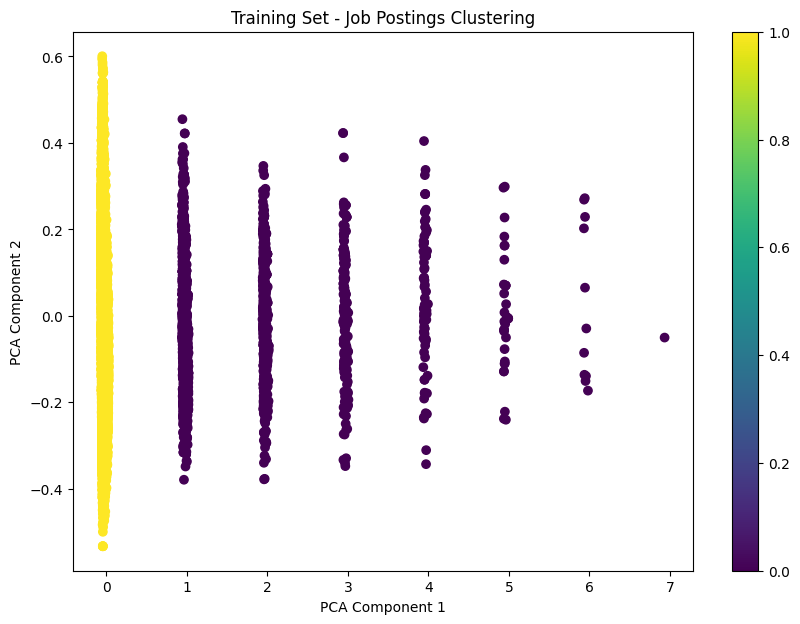

In [15]:
# Visualization of Training Set
pca = PCA(n_components=2)
reduced_train_vectors = pca.fit_transform(X_train)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_train_vectors[:, 0], reduced_train_vectors[:, 1], c=train_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Training Set - Job Postings Clustering')
plt.colorbar()
plt.show()

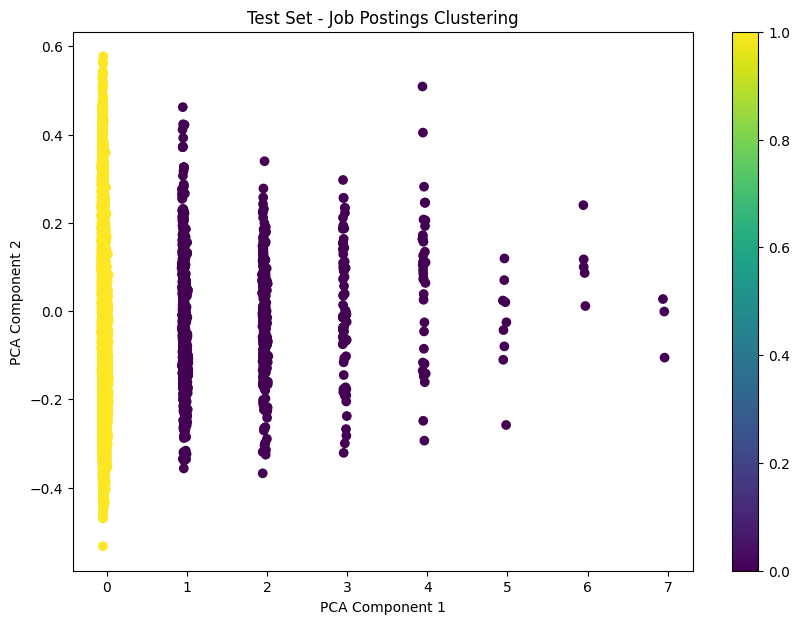

In [16]:
# Visualization of Test Set
reduced_test_vectors = pca.transform(X_test)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_test_vectors[:, 0], reduced_test_vectors[:, 1], c=test_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Test Set - Job Postings Clustering')
plt.colorbar()
plt.show()

In [17]:
# Determine which label belongs to which class
acc = accuracy_score(y_train, train_labels)
acc2 = accuracy_score(1-y_train, train_labels)
print(acc, acc2)

0.0 1.0


From the computation from the previous cell, the 0 -> ML and 1 -> Non ML

In [18]:
# Analyze the clusters to determine which is ML-related and which is non-ML-related
df_train = pd.DataFrame(y_train, columns=["ml_ai_keyword"])
df_train['Cluster'] = train_labels


df_test = pd.DataFrame(y_test, columns=["ml_ai_keyword"])
df_test['Cluster'] = test_labels


# Assigning labels to clusters for interpretation
cluster_label_mapping = {0: 'ML', 1: 'Non-ML'}
df_train['Cluster Label'] = df_train['Cluster'].map(cluster_label_mapping)
df_test['Cluster Label'] = df_test['Cluster'].map(cluster_label_mapping)


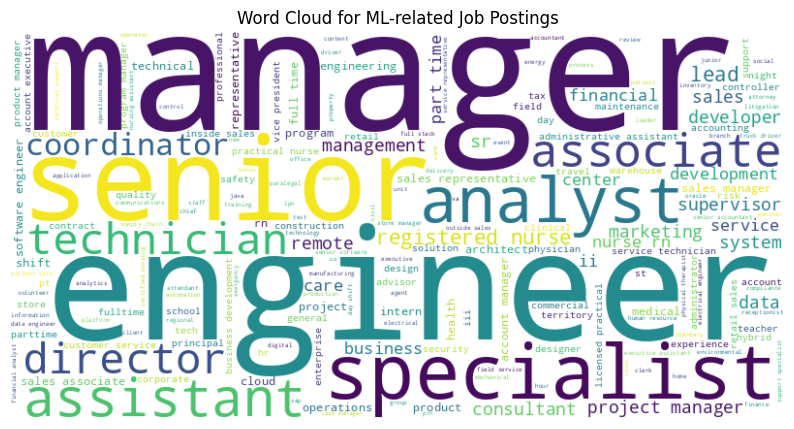

In [21]:
# Create a word cloud for the ML-related job postings in the test set
ml_related_jobs = job_postings.iloc[df_train.index[train_labels == 0]]
ml_related_texts = ml_related_jobs['title'] # + ' ' + ml_related_jobs['description']
combined_ml_related_texts = ' '.join(ml_related_texts.apply(preprocess_text))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_ml_related_texts)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for ML-related Job Postings')
plt.show()

In [23]:
# Print original job postings with their assigned cluster labels for test set
for i, job in job_postings.iterrows():
    if i in df_test.index and df_test.loc[i, 'Cluster Label'] == 'ML':
        print(f"Job Title: {job['title']}, Cluster: {df_test.loc[i, 'Cluster Label']}")

Job Title: Worship Leader, Cluster: ML
Job Title: Assistant Director, Cluster: ML
Job Title: Senior Software Engineer, Cluster: ML
Job Title: Pediatric Occupational Therapy, Cluster: ML
Job Title: Inbound Sales & Onboarding Specialist, Cluster: ML
Job Title: Histology Supervisor, Cluster: ML
Job Title: Project Estimator, Cluster: ML
Job Title: FL Bar Associate Attorney Tax, Trusts, and Estates, Cluster: ML
Job Title: Service Specialist, Cluster: ML
Job Title: üöÄ Join Our Team as a Senior iOS Developer at ABHI IT SYSTEMS INC üåê üöÄ, Cluster: ML
Job Title: Mentorship Case Manager, Cluster: ML
Job Title: Pilot in Command Phenom 300, Cluster: ML
Job Title: Senior Data Engineer/Analyst - Full Time, Cluster: ML
Job Title: PeopleSoft FSCM Functional Analyst - GL and KK modules, Cluster: ML
Job Title: IAM Security Specialist, Cluster: ML
Job Title: Part Time Driver (Manheim), Cluster: ML
Job Title: Junior Engineer - [Full Remote], Cluster: ML
Job Title: Education Budget Manager , Cluster:

Job Title: Assistant Director, OCPD (Health Careers Team), Cluster: ML
Job Title: Associate Scientist, QC, Cluster: ML
Job Title: Volunteer: Castellow Hammock EcoAction Day (April 2024), Cluster: ML
Job Title: Master Plumber, Cluster: ML
Job Title: Information Security Director, Cluster: ML
Job Title: Technical Project Manager, US, Cluster: ML
Job Title: Resident Chef, Cluster: ML
Job Title: Volunteer: Sociocracy Volunteer, Cluster: ML
Job Title: Food Service Manager, Cluster: ML
Job Title: Senior Business Systems Analyst, Cluster: ML
Job Title: OIM¬†Developer, Cluster: ML
Job Title: Infotainment Developer, Cluster: ML
Job Title: Industrial Hygiene Professional, Cluster: ML
Job Title: Application Support Analyst, Cluster: ML
Job Title: Senior Structural Engineer, Cluster: ML
Job Title: Production Coordinator (Hrly), Cluster: ML
Job Title: Legal Assistant (REMOTE), Cluster: ML
Job Title: Special Education, P-12, Educational Interpreter - DHH - Special Education Rover, Cluster: ML
Job Ti

Job Title: Full Line Sales Specialist, Cluster: ML
Job Title: CERTIFIED NURSING ASSISTANT - BRADLEY CREEK HEALTH CENTER, Cluster: ML
Job Title: LICENSED PRACTICAL NURSE - PARKVIEW HEALTH AND REHABILITATION CENTER, Cluster: ML
Job Title: Information Technology Security Analyst, Cluster: ML
Job Title: Coaching Vacancies (Modesto High School) Open to Modesto City Schools Permanent and Probationary Certificated Employees Only, Cluster: ML
Job Title: Full Line Sales Specialist, Cluster: ML
Job Title: Customer Service Representative, Cluster: ML
Job Title: Account Manager, Immunology - Phoenix - South, AZ, Cluster: ML
Job Title: Financial Controller, Cluster: ML
Job Title: Accountant, Cluster: ML
Job Title: Payroll Operations Manager US & CANADA, Cluster: ML
Job Title: IMMEDIATE HIRE: Entry Level Sales & Marketing, Cluster: ML
Job Title: Warehouse/Production Assistant, Cluster: ML
Job Title: ERP Project Manager, Cluster: ML
Job Title: Head of Growth, Cluster: ML
Job Title: Physical Therapist

Job Title: Driver/Operator, Cluster: ML
Job Title: Immigration Specialist, Cluster: ML
Job Title: PCU/Step-down Nurse, Cluster: ML
Job Title: Deli Associate, Cluster: ML
Job Title: Registered Nurse Supervisor - RN - Long Term Care/Skilled Nursing Facility, Cluster: ML
Job Title: Registered Nurse - RN - LTAC, Cluster: ML
Job Title: Department Manager Starbucks - Glendale, AZ - 2821, Cluster: ML
Job Title: Designer, Cluster: ML
Job Title: Junior Illustrator, Cluster: ML
Job Title: Registered Nurse - RN - ER (Emergency Room), Cluster: ML
Job Title: Barista, Cluster: ML
Job Title: Auto Body Technician, Cluster: ML
Job Title: Orthodontic Assistant, Cluster: ML
Job Title: Project Manager, Cluster: ML
Job Title: Retail Sales Associate, Metro Center - Part Time, Cluster: ML
Job Title: Radiology Tech Assistant, FT - Sun View, Cluster: ML
Job Title: Lead Engineer, Structural, Cluster: ML
Job Title: Intern - Operations, Cluster: ML
Job Title: Community Turn Assistant (Temporary), Cluster: ML
Job 

From the visulaistion above we can see some of the jobs that currently categorised as ML related. We need a better model and we need to train a proper classification algorithm for this task. We can't simply realy on clustering with the augmented features as we did in this notebook.